<a href="https://colab.research.google.com/github/Servat0r/ISPR-Midterms-2023/blob/master/Midterm3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm 3 ISPR 2023 - Assignment 2 - Salvatore Correnti (matr. 584136)
In this assignment we will design and test on the `CIFAR-10` dataset a custom Convolutional Neural Network.

## Initial Imports
As usual, we start with a couple of cells for changing working directory and for all necessary imports before actually starting coding.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Github/ISPR-Midterms-2023"

/content/drive/MyDrive/Github/ISPR-Midterms-2023


In [ ]:
# Below is just to make sure we can build Tensorflow with GPU and to avoid a verbose output for installation
!pip install tensorflow 1> /dev/null

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical

## CIFAR-10 Dataset
For training and evaluating our Convolutional Neural Network, we will use the `CIFAR-10` dataset, which is made up of $50,000$ train and $10,000$ test $32 \times 32$ RGB images, and is available in `keras` as a "built-in" dataset.

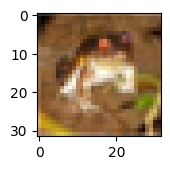

In [ ]:
%matplotlib inline
(x_dev, y_dev), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Show an image as an example
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.6))
ax.imshow(x_dev[0], interpolation='nearest', cmap='gray')

We now convert CIFAR-10 labels into `one-hot` format for usage with a "Sotfmax-based" CNN classifier.

In [ ]:
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)
y_dev[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

Before proceeding, we also normalize pixel values into the range $[0, 1]$ and we split training data into properly training ones and validation ones (we will keep test data to evaluate the final model).

In [ ]:
x_dev = x_dev.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

from sklearn.model_selection import train_test_split

x_train, x_eval, y_train, y_eval = train_test_split(x_dev, y_dev, test_size=0.2, random_state=0)

## Designing a Convolutional Neural Network for CIFAR-10
When designing a custom Convolutional Neural Network for a specific task, it is important to take into account at least the most important "building blocks" for CNNs that have been developed through the years and used in "reference" models. Indeed, since CNNs are in usage by about a decade, it is convenient to take inspiration or directly modify one of these reference models to achieve our objectives. Also, monitoring the accuracy and the space and time required for training a given model (e.g. by calculating the number of parameters) is also fundamental, and in particular since we don't have required hardware for huge models we want to get a tradeoff between accuracy and size of the model.

We will then go through our discussion throughout the following design choices:

1. `Target Accuracy`: we want to achieve an accuracy at least $\geq 70\%$, since this is the accuracy that one can easily get with a "reduced" `VGG` model (see below). On top of that, we can consider additional design choices based on what we get from experiments for achieving a higher one;
2. `"Style" of the CNN`: we will use the "traditional" design pattern of a series of Convolutional-MaxPooling layers, ended by a `Fully-Connected` block and `Softmax` activation, as employed in `AlexNet`, `VGG` and (apart from MaxPool) in `GoogLeNet`;
3. `Base Model`: since `CIFAR-10` images are of size $32 \times 32$, we are not interested in very deep networks for reducing the feature maps sizes up to reasonable values for usage with a final sequence of fully-connected layers, or in other words if we use `max-pooling` with a pool size of $(2, 2)$, it suffices to employ $3$ `MaxPool2D` layers to get a feature map of size $\leq 4 \times 4$, and if we suppose to have $N$ filters at the end, we will get $16N$ input units for the `dense` part of the network, which can be reasonable if we take for example a single hidden layer with a size $\leq 128$, or we directly skip the `dense hidden` layers. As a consequence, we will model our CNNs as a sort of "reduced" version of `VGG`, which has proved to be quite effective in classification tasks over `ImageNet`;
4. `Number of Parameters`: ideally, we want to keep $< 1,000,000$ parameters for our Convolutional Neural Network, which is suitable for a 2-deep or 3-deep (in the sense of Conv2D-MaxPool blocks) `VGG-like` network. After having built a "satisfactory" network without explicit design choices for restricting the number of parameters, we can explore usage of $1 \times 1$ convolutions and reduced `Dense` blocks to reduce the number of parameters while retaining most of the accuracy;
5. `Regularization`: since a `VGG-like` CNN can quickly become quite big, especially in the `Dense` part, it is essential to adopt regularization strategies to limit overfitting and improving overall performance. From an architectural point of view, two viable yet effective strategies are `Dropout` and `Batch Normalization`, and we will experiment with both of them to see if we can improve overall performance of the network;
6. `Advanced Blocks`: if we manage to keep our network "sufficiently small" (i.e. with 2 or 3 Conv2D-MaxPool blocks), we may not use advanced architectural patterns like `Skip Connections` and `Inception Blocks`, which complicate the design and coding of the Neural Network, especially if we can keep under control `vanishing gradient` phenomena by avoiding a too deep network.

### VGG Network
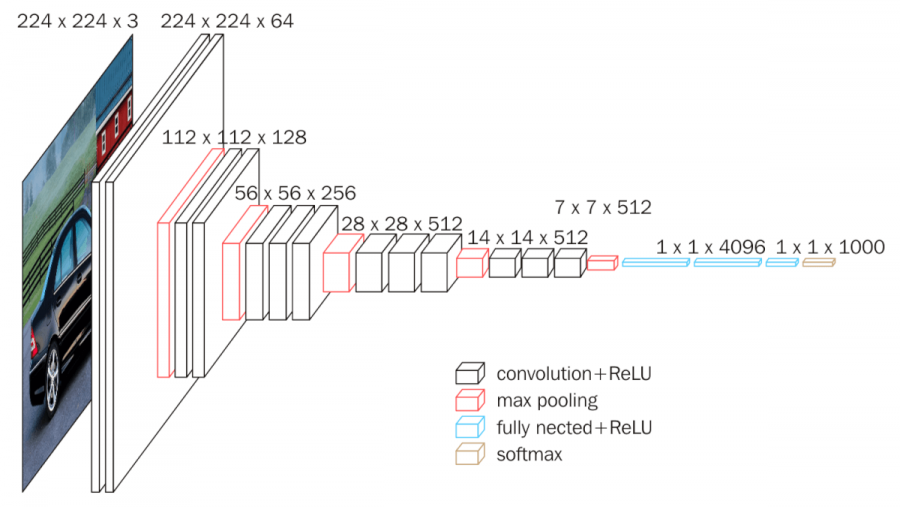

**`VGG16`** (**`Visual Geometry Group 16`**) network was proposed by Karen Simonyan and Andrew Zisserman of the `Visual Geometry Group Lab` of `Oxford University` in 2014 and won the 2014 `ILSVRC` competition on the `ImageNet` dataset. As we can see in the above figure, VGG16 is composed by a sequence of $5$ `Conv2D-Conv2D-MaxPool` blocks, i.e. 2 Convolutional Layers with `same` padding and $3 \times 3$ kernel sizes, followed by a single MaxPooling layer with pool size of $2 \times 2$ for reducing feature maps sizes. As we can see, each block contains 2 Convolutional Layer with an increasing number of filters for each one ($64$, $128$, $256$, $512$, $512$) and a single hidden layer of size $4096$.

The idea behind this pattern is that by reducing the size of the feature maps we are progressively representing "higher-level" features that somehow "summarize" information by lower-level ones, hence the number of "descriptors" we want to keep should be increasing when we traverse the network, and moreover we want to let "feature descriptors" from more and more distant areas of the image to combine themselves.

#### Reduced VGG
We can keep the above design pattern in our CNN by simply reducing the number of Blocks and the size of the hidden layer, or by removing it at all. For example, we can employ a first block made up of two convolutional layers each one with $32$ filters of size $3 \times 3$, a second one with $64$ filters and a third one of $128$ ones. As in VGG16, we use `same` padding even if it may introduce some form of bias due to the padding value since we are using a very small kernel.

We will start with a "simple" Reduced VGG without any Dropout, Batch Normalization or Dense Hidden Layer to see if this is a viable baseline.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization

In [ ]:
def plot_results(history: tf.keras.callbacks.History):
    fig, ax = plt.subplots(1, 2)
    epochs = np.arange(1, 11)
    trainLoss, validationLoss = history.history['loss'], history.history['val_loss']
    trainAccuracy, validationAccuracy = history.history['accuracy'], history.history['val_accuracy']
    ax[0].plot(epochs, trainLoss, label='Training Loss')
    ax[0].plot(epochs, validationLoss, label='Validation Loss')
    ax[1].plot(epochs, trainAccuracy, label='Training Accuracy')
    ax[1].plot(epochs, validationAccuracy, label='Validation Accuracy')

In [ ]:
baseReducedVGG = Sequential()

baseReducedVGG.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(32,32,3), padding='same'))
baseReducedVGG.add(Conv2D(32, kernel_size=3, activation="relu", padding='same'))
baseReducedVGG.add(MaxPool2D())

baseReducedVGG.add(Conv2D(64, kernel_size=3, activation="relu", padding='same'))
baseReducedVGG.add(Conv2D(64, kernel_size=3, activation="relu", padding='same'))
baseReducedVGG.add(MaxPool2D())

baseReducedVGG.add(Conv2D(128, kernel_size=3, activation="relu", padding='same'))
baseReducedVGG.add(Conv2D(128, kernel_size=3, activation="relu", padding='same'))
baseReducedVGG.add(MaxPool2D())

# Now we flatten for fully-connected part
baseReducedVGG.add(Flatten())
baseReducedVGG.add(Dense(10, activation="softmax"))
baseReducedVGG.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

As we can see, our `baseReducedVGG` model has $307,498$ parameters, which is a reasonable amount and far below the $1,000,000$ maximum we mentioned before. We also notice that since we have not used any Dense hidden layer, the two Conv2D layers with $128$ filters contribute for $\approx 75\%$ of the total parameters, hence we will not use any higher number of filters to keep number of parameters (hence training time) under control.

We now compile and train the model with a batch size of $64$ and for $10$ epochs, using `Adam` optimizer and `Categorical Cross Entropy` loss:

In [ ]:
baseReducedVGG.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
baseReducedVGGHistory = baseReducedVGG.fit(
    x_train, y_train, validation_data=(x_eval, y_eval), epochs=10, batch_size=64,
    callbacks=[tf.keras.callbacks.CSVLogger('baseReducedVGG_log.csv')],
)

Epoch 1/10
625/625 [==============================] - 79s 125ms/step - loss: 1.5863 - accuracy: 0.4221 - val_loss: 1.2436 - val_accuracy: 0.5530
Epoch 2/10
625/625 [==============================] - 79s 126ms/step - loss: 1.0726 - accuracy: 0.6205 - val_loss: 1.0072 - val_accuracy: 0.6447
Epoch 3/10
625/625 [==============================] - 78s 125ms/step - loss: 0.8547 - accuracy: 0.7020 - val_loss: 0.8216 - val_accuracy: 0.7155
Epoch 4/10
625/625 [==============================] - 78s 125ms/step - loss: 0.7181 - accuracy: 0.7482 - val_loss: 0.7752 - val_accuracy: 0.7335
Epoch 5/10
625/625 [==============================] - 79s 126ms/step - loss: 0.6016 - accuracy: 0.7892 - val_loss: 0.7878 - val_accuracy: 0.7331
Epoch 6/10
625/625 [==============================] - 79s 127ms/step - loss: 0.5137 - accuracy: 0.8229 - val_loss: 0.7964 - val_accuracy: 0.7399
Epoch 7/10
625/625 [==============================] - 80s 129ms/step - loss: 0.4272 - accuracy: 0.8499 - val_loss: 0.7840 - val_ac

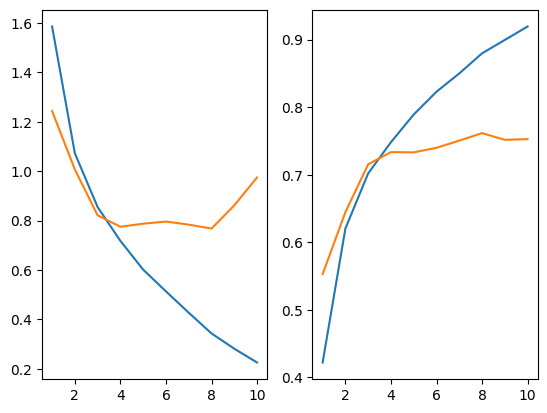

In [ ]:
%matplotlib inline
plot_results(baseReducedVGGHistory)

As we can see, we already got a very high training accuracy ($91.94\%$) and a quite high validation one ($75.27\%$). However, from the plots above we clearly notice that the model is overfitting after $\approx 4$ epochs, hence we will need to introduce regularization. As already said, this test is to actually verify that a "base" ReducedVGG actually works well with CIFAR-10. We now move onto adding Dropout and Batch Normalization.

In [ ]:
baseReducedVGG.save('baseReducedVGG')

INFO:tensorflow:Assets written to: baseReducedVGG\assets


INFO:tensorflow:Assets written to: baseReducedVGG\assets


#### Adding Dropout and Batch Normalization
We will add a `BatchNormalization` layer after each Convolutional, MaxPooling and non-output Dense layer, since we want to avoid each possible "internal shift" in the distribution that the network is learning. By contrary, we can add Dropout layers after each Conv2D-MaxPool block, since we do not have any trainable parameter in Dropout layers and moreover its effect as regularizer is actually to train an implicit emsembler of subnetworks inside the original one, and we do not want to "fragment" too much the network; in particular, we want to keep Conv2D-MaxPool blocks as "units" for the underlying subnetworks.

We do not want to do any hyperparameter tuning by now, hence we set Dropout probabilities to standard values of $0.2$ and $0.3$, paying attention to the fact that as we increase the number of filters and hence the number of parameters we want a higher regularization effect, hence a higher Dropout probability.

In [ ]:
regularizedReducedVGG = Sequential()

regularizedReducedVGG.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(32,32,3), padding='same'))
regularizedReducedVGG.add(BatchNormalization())
regularizedReducedVGG.add(Conv2D(32, kernel_size=3, activation="relu", padding='same'))
regularizedReducedVGG.add(BatchNormalization())
regularizedReducedVGG.add(MaxPool2D())
regularizedReducedVGG.add(BatchNormalization())
regularizedReducedVGG.add(Dropout(0.2))

regularizedReducedVGG.add(Conv2D(64, kernel_size=3, activation="relu", padding='same'))
regularizedReducedVGG.add(BatchNormalization())
regularizedReducedVGG.add(Conv2D(64, kernel_size=3, activation="relu", padding='same'))
regularizedReducedVGG.add(BatchNormalization())
regularizedReducedVGG.add(MaxPool2D())
regularizedReducedVGG.add(BatchNormalization())
regularizedReducedVGG.add(Dropout(0.3))

regularizedReducedVGG.add(Conv2D(128, kernel_size=3, activation="relu", padding='same'))
regularizedReducedVGG.add(BatchNormalization())
regularizedReducedVGG.add(Conv2D(128, kernel_size=3, activation="relu", padding='same'))
regularizedReducedVGG.add(BatchNormalization())
regularizedReducedVGG.add(MaxPool2D())
regularizedReducedVGG.add(BatchNormalization())
regularizedReducedVGG.add(Dropout(0.3))

regularizedReducedVGG.add(Flatten())
regularizedReducedVGG.add(BatchNormalization())
regularizedReducedVGG.add(Dense(10, activation="softmax"))

regularizedReducedVGG.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [ ]:
regularizedReducedVGG.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
regularizedReducedVGGHistory = regularizedReducedVGG.fit(
    x_train, y_train, validation_data=(x_eval, y_eval), epochs=10, batch_size=64,
    callbacks=[tf.keras.callbacks.CSVLogger('baseReducedVGG_log.csv')],
)

Epoch 1/10
625/625 [==============================] - 109s 171ms/step - loss: 1.4828 - accuracy: 0.4963 - val_loss: 1.1231 - val_accuracy: 0.6089
Epoch 2/10
625/625 [==============================] - 109s 174ms/step - loss: 1.0166 - accuracy: 0.6505 - val_loss: 0.9321 - val_accuracy: 0.6865
Epoch 3/10
625/625 [==============================] - 110s 176ms/step - loss: 0.8602 - accuracy: 0.7037 - val_loss: 0.9076 - val_accuracy: 0.7031
Epoch 4/10
625/625 [==============================] - 108s 173ms/step - loss: 0.7634 - accuracy: 0.7372 - val_loss: 0.7947 - val_accuracy: 0.7378
Epoch 5/10
625/625 [==============================] - 108s 172ms/step - loss: 0.6994 - accuracy: 0.7563 - val_loss: 0.6937 - val_accuracy: 0.7702
Epoch 6/10
625/625 [==============================] - 107s 171ms/step - loss: 0.6464 - accuracy: 0.7747 - val_loss: 0.6789 - val_accuracy: 0.7748
Epoch 7/10
625/625 [==============================] - 107s 171ms/step - loss: 0.6034 - accuracy: 0.7908 - val_loss: 0.6473 -

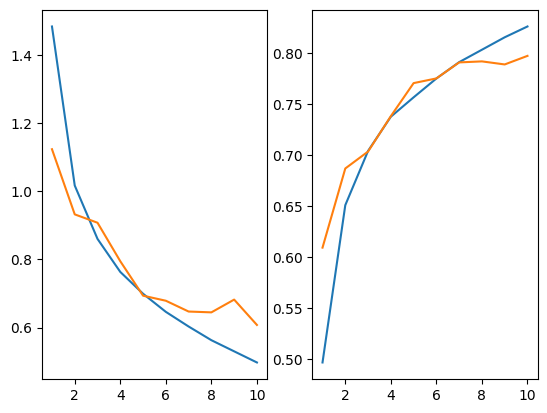

In [ ]:
%matplotlib inline
plot_results(regularizedReducedVGGHistory)

We notice that now final training accuracy if lower than in the previous case ($82.57\%$ against $91.94\%$), but on the bright side we got an improvement in the validation accuracy of about $4\%$, hence we can keep Dropout and BatchNormalization inside our final network.

In [ ]:
regularizedReducedVGG.save('regularizedReducedVGG')

INFO:tensorflow:Assets written to: regularizedReducedVGG\assets


INFO:tensorflow:Assets written to: regularizedReducedVGG\assets


#### Adding Dense layers
We now try to add `Dense` hidden layers in the final part of the network to see if this improves accuracy. As already seen, after Conv2D-MaxPool blocks we have $2048$ parameters in the flattened array, hence if we insert a hidden layer of size $m$, we get $2058m$ parameters. To keep the total number of parameters $< 1,000,000$, and possibly $< 500,000$ but without forcing the network to "simplify" too much the representation in the flattened array, we can take a hidden size of $128$. As for the previous network, we add a BatchNormalization layer and a Dropout one after the hidden layer and we use a Dropout probability of $0.5$.

In [ ]:
dense128ReducedVGG = Sequential()

dense128ReducedVGG.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(32,32,3), padding='same'))
dense128ReducedVGG.add(BatchNormalization())
dense128ReducedVGG.add(Conv2D(32, kernel_size=3, activation="relu", padding='same'))
dense128ReducedVGG.add(BatchNormalization())
dense128ReducedVGG.add(MaxPool2D())
dense128ReducedVGG.add(Dropout(0.2))
dense128ReducedVGG.add(BatchNormalization())

dense128ReducedVGG.add(Conv2D(64, kernel_size=3, activation="relu", padding='same'))
dense128ReducedVGG.add(BatchNormalization())
dense128ReducedVGG.add(Conv2D(64, kernel_size=3, activation="relu", padding='same'))
dense128ReducedVGG.add(BatchNormalization())
dense128ReducedVGG.add(MaxPool2D())
dense128ReducedVGG.add(Dropout(0.3))
dense128ReducedVGG.add(BatchNormalization())

dense128ReducedVGG.add(Conv2D(128, kernel_size=3, activation="relu", padding='same'))
dense128ReducedVGG.add(BatchNormalization())
dense128ReducedVGG.add(Conv2D(128, kernel_size=3, activation="relu", padding='same'))
dense128ReducedVGG.add(BatchNormalization())
dense128ReducedVGG.add(MaxPool2D())
dense128ReducedVGG.add(Dropout(0.3))
dense128ReducedVGG.add(BatchNormalization())

dense128ReducedVGG.add(Flatten())
dense128ReducedVGG.add(BatchNormalization())
dense128ReducedVGG.add(Dense(128, activation="relu", kernel_initializer="he_uniform", bias_initializer="he_uniform"))
dense128ReducedVGG.add(Dropout(0.5))
dense128ReducedVGG.add(BatchNormalization())
dense128ReducedVGG.add(Dense(10, activation="softmax"))

dense128ReducedVGG.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_11 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [ ]:
dense128ReducedVGG.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
dense128ReducedVGGHistory = dense128ReducedVGG.fit(
    x_train, y_train, validation_data=(x_eval, y_eval), epochs=10, batch_size=64,
    callbacks=[tf.keras.callbacks.CSVLogger('baseReducedVGG_log.csv')],
)

Epoch 1/10
625/625 [==============================] - 113s 178ms/step - loss: 1.5929 - accuracy: 0.4412 - val_loss: 1.1620 - val_accuracy: 0.5776
Epoch 2/10
625/625 [==============================] - 110s 175ms/step - loss: 1.0954 - accuracy: 0.6140 - val_loss: 0.8970 - val_accuracy: 0.6804
Epoch 3/10
625/625 [==============================] - 109s 174ms/step - loss: 0.9193 - accuracy: 0.6780 - val_loss: 0.8376 - val_accuracy: 0.7031
Epoch 4/10
625/625 [==============================] - 109s 175ms/step - loss: 0.8269 - accuracy: 0.7133 - val_loss: 0.7526 - val_accuracy: 0.7385
Epoch 5/10
625/625 [==============================] - 109s 175ms/step - loss: 0.7445 - accuracy: 0.7434 - val_loss: 0.6754 - val_accuracy: 0.7642
Epoch 6/10
625/625 [==============================] - 109s 175ms/step - loss: 0.6886 - accuracy: 0.7633 - val_loss: 0.6483 - val_accuracy: 0.7751
Epoch 7/10
625/625 [==============================] - 109s 175ms/step - loss: 0.6360 - accuracy: 0.7801 - val_loss: 0.6139 -

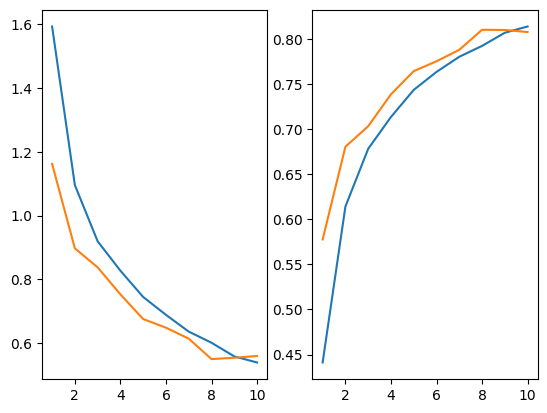

In [ ]:
%matplotlib inline
plot_results(dense128ReducedVGGHistory)

As we can see, we got a small improvement in validation accuracy of about $1\%$, while training one is stable. We can then keep the hidden Dense layer of size $128$ and test the final model on the Test Set.

We now evaluate the model over the Test Set:

In [ ]:
test_metrics = dense128ReducedVGG.evaluate(x_test, y_test, batch_size=64, return_dict=True)
print(f"Test Set Loss = {test_metrics['loss']:.4f}")
print(f"Test Set Accuracy = {(100 * test_metrics['accuracy']):.4f}%")

157/157 [==============================] - 6s 34ms/step - loss: 0.5681 - accuracy: 0.8056
Test Set Loss = 0.5681
Test Set Accuracy = 80.5600%


In [ ]:
dense128ReducedVGG.save('dense128ReducedVGG')

INFO:tensorflow:Assets written to: dense128ReducedVGG\assets


INFO:tensorflow:Assets written to: dense128ReducedVGG\assets


To summarize, our custom Convolutional Neural Network has the following structure:
* A sequence of two **Convolutional Layers** with $32$ filters of size $3 \times 3$ with `same` padding and **Batch Normalization** after each layer;
* A **MaxPool** layer of pooling size of $2 \times 2$, followed by a **Dropout** layer with a (default) dropout probability of $0.2$ and another **Batch Normalization** one;
* A sequence of two **Convolutional Layers** with $64$ filters of size $3 \times 3$ with `same` padding and **Batch Normalization** after each layer;
* A **MaxPool** layer of pooling size of $2 \times 2$, followed by a **Dropout** layer with a (default) dropout probability of $0.3$ and another **Batch Normalization** one;
* A sequence of two **Convolutional Layers** with $128$ filters of size $3 \times 3$ with `same` padding and **Batch Normalization** after each layer;
* A **MaxPool** layer of pooling size of $2 \times 2$, followed by a **Dropout** layer with a (default) dropout probability of $0.3$ and another **Batch Normalization** one;
* After that, the output is flattened to an array of size $2048$ and forwarded to a **Dense** layer of size $2048 \times 128$;
* Finally, we have another **Dense** layer of size $128 \times 10$ and a **Softmax** layer for outputting probability distributions over the $10$ classes for the given input.

Our network is a sort of `"ReducedVGG"` in the sense that follows the architectural pattern of `VGG16`, but it adapts it to the smaller size of `CIFAR-10` images and introduces `Dropout` and `BatchNormalization` for having regularization and robustness against internal distribution shifts. We have used neither any Skip or Residual Connections nor any `Inception` module to keep the model simple ($561,962$ parameters) while still retaining a good accuracy in the range $80-82\%$.

### More Experiments

We now try to alter several input images to see how the network performs with respect to modifications in the inputs, i.e. how much the network is *robust* in its classification task.

We will produce a sequence of "occluded images", i.e. we will take a gray patch of $N \times N$ pixels (with $1 \leq N \leq 31$) that we will slide over all the image and we will monitor the accuracy in predicting the (possibly correct) original prediction when the image gets altered.

In [ ]:
def get_occluded_images(src_image: np.ndarray, label: int, num_classes: int, patch_size: int, color=0.5):
    num_images = (32 - patch_size)**2
    x = np.zeros((num_images,) + src_image.shape, dtype=src_image.dtype)
    y = to_categorical(np.full(num_images, label), num_classes)
    for i in range(num_images):
        np.copyto(dst=x[i], src=src_image)
    k = 0
    for i in range(32 - patch_size):
        for j in range(32 - patch_size):
            x[k, i:i+patch_size, j:j+patch_size] = color
            k += 1
    return x, y

We now divide the Test Set images by their classes:

In [ ]:
indexes = np.array([[x_test[i] for i in range(10_000) if np.argmax(y_test[i]) == classId] for classId in range(10)])
print(indexes.shape, *[len(indexes[i]) for i in range(10)])

(10, 1000, 32, 32, 3) 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000


We load the models after having saved them (for reproducibility):

In [ ]:
baseReducedVGG = tf.keras.models.load_model('baseReducedVGG')
regularizedReducedVGG = tf.keras.models.load_model('regularizedReducedVGG')
dense128ReducedVGG = tf.keras.models.load_model('dense128ReducedVGG')

For simplicity, we choose one image per class such that the corresponding prediction by the model is correct:

In [ ]:
test_images = np.array([indexes[i, 7] for i in range(10)])
print(test_images.shape)

(10, 32, 32, 3)


In [ ]:
predicted_labels = dense128ReducedVGG.predict(test_images)
print(np.argmax(predicted_labels, axis=-1))

1/1 [==============================] - 0s 427ms/step
[0 1 2 3 4 5 6 7 8 9]


We now define a helper function for using different patch sizes:

In [ ]:
def calculate_accuracy_with_patch(images, patch_size, model):
    results = []
    num_images = (32 - patch_size)**2
    for i in range(10):
        x_occluded, y_occluded = get_occluded_images(images[i], i, 10, patch_size)
        predicted_occluded = model.predict(x_occluded)
        predicted_occluded = to_categorical(np.argmax(predicted_occluded, axis=-1), 10)
        occluded_errors = np.max(np.abs(predicted_occluded - y_occluded), axis=-1)
        errors = int(np.sum(occluded_errors))
        accuracy = 1 - errors/num_images
        print(f"{errors} errors in predicting image label {i}")
        print(f"Accuracy in predicting image label {i}: {100 * accuracy:.4f}%")
        results.append({
            'total_images': num_images,
            'errors': errors,
            'accuracy': accuracy,
        })
    return results

In [ ]:
print("Results with a patch of 2: ")
occlusion2results = calculate_accuracy_with_patch(test_images, 2, dense128ReducedVGG)

Results with a patch of 2: 
29/29 [==============================] - 1s 48ms/step
0 errors in predicting image label 0
Accuracy in predicting image label 0: 100.0000%
29/29 [==============================] - 1s 48ms/step
0 errors in predicting image label 1
Accuracy in predicting image label 1: 100.0000%
29/29 [==============================] - 1s 46ms/step
93 errors in predicting image label 2
Accuracy in predicting image label 2: 89.6667%
29/29 [==============================] - 1s 46ms/step
0 errors in predicting image label 3
Accuracy in predicting image label 3: 100.0000%
29/29 [==============================] - 1s 48ms/step
116 errors in predicting image label 4
Accuracy in predicting image label 4: 87.1111%
29/29 [==============================] - 1s 47ms/step
162 errors in predicting image label 5
Accuracy in predicting image label 5: 82.0000%
29/29 [==============================] - 1s 49ms/step
0 errors in predicting image label 6
Accuracy in predicting image label 6: 100.000

In [ ]:
print('Results with a patch of 4: ')
occlusion4results = calculate_accuracy_with_patch(test_images, 4, dense128ReducedVGG)

Results with a patch of 4: 
25/25 [==============================] - 1s 48ms/step
0 errors in predicting image label 0
Accuracy in predicting image label 0: 100.0000%
25/25 [==============================] - 1s 48ms/step
0 errors in predicting image label 1
Accuracy in predicting image label 1: 100.0000%
25/25 [==============================] - 1s 46ms/step
147 errors in predicting image label 2
Accuracy in predicting image label 2: 81.2500%
25/25 [==============================] - 1s 47ms/step
0 errors in predicting image label 3
Accuracy in predicting image label 3: 100.0000%
25/25 [==============================] - 1s 49ms/step
147 errors in predicting image label 4
Accuracy in predicting image label 4: 81.2500%
25/25 [==============================] - 1s 47ms/step
270 errors in predicting image label 5
Accuracy in predicting image label 5: 65.5612%
25/25 [==============================] - 1s 47ms/step
0 errors in predicting image label 6
Accuracy in predicting image label 6: 100.00

In [ ]:
print('Results with a patch of 8: ')
occlusion8results = calculate_accuracy_with_patch(test_images, 8, dense128ReducedVGG)

Results with a patch of 8: 
18/18 [==============================] - 1s 47ms/step
5 errors in predicting image label 0
Accuracy in predicting image label 0: 99.1319%
18/18 [==============================] - 1s 47ms/step
0 errors in predicting image label 1
Accuracy in predicting image label 1: 100.0000%
18/18 [==============================] - 1s 47ms/step
237 errors in predicting image label 2
Accuracy in predicting image label 2: 58.8542%
18/18 [==============================] - 1s 49ms/step
0 errors in predicting image label 3
Accuracy in predicting image label 3: 100.0000%
18/18 [==============================] - 1s 46ms/step
212 errors in predicting image label 4
Accuracy in predicting image label 4: 63.1944%
18/18 [==============================] - 1s 45ms/step
447 errors in predicting image label 5
Accuracy in predicting image label 5: 22.3958%
18/18 [==============================] - 1s 50ms/step
6 errors in predicting image label 6
Accuracy in predicting image label 6: 98.9583

In [ ]:
print('Results with a patch of 16: ')
occlusion16results = calculate_accuracy_with_patch(test_images, 16, dense128ReducedVGG)

Results with a patch of 16: 
8/8 [==============================] - 0s 58ms/step
67 errors in predicting image label 0
Accuracy in predicting image label 0: 73.8281%
8/8 [==============================] - 0s 49ms/step
154 errors in predicting image label 1
Accuracy in predicting image label 1: 39.8438%
8/8 [==============================] - 1s 49ms/step
108 errors in predicting image label 2
Accuracy in predicting image label 2: 57.8125%
8/8 [==============================] - 0s 53ms/step
54 errors in predicting image label 3
Accuracy in predicting image label 3: 78.9062%
8/8 [==============================] - 0s 54ms/step
125 errors in predicting image label 4
Accuracy in predicting image label 4: 51.1719%
8/8 [==============================] - 0s 48ms/step
253 errors in predicting image label 5
Accuracy in predicting image label 5: 1.1719%
8/8 [==============================] - 0s 49ms/step
185 errors in predicting image label 6
Accuracy in predicting image label 6: 27.7344%
8/8 [===

As we can see, the network is quite robust with respect to such alterations: in particular, for classes $0, 1, 3, 6, 8$ it is necessary to use a patch of size $\geq 8$ to get an accuracy significantly $< 100\%$, and for some of them like class $8$, even with a patch of size $16$ the network is still able to maintain an accuracy of $98.4375\%$, which means that for half of the classes actually the network is highly confident in its predictions. Weaker results are shown for classes $2, 4, 5, 7$, while classes $9$ is in a sort of "intermediate" situation, and in particular it seems that the network is not well capable of identifying objects of class $5$, since we notice a dramatic decrease in accuracy from $82\%$ to $1\%$.

We can compare this with the Confusion Matrix of the network:

In [ ]:
from sklearn.metrics import confusion_matrix
predicted = dense128ReducedVGG.predict(x_test)
sparse_ytest = np.argmax(y_test, axis=-1)
sparse_ypredicted = np.argmax(predicted, axis=-1)
matrix = confusion_matrix(sparse_ytest, sparse_ypredicted)
print(matrix)

313/313 [==============================] - 5s 16ms/step
[[734   7  36  27  49   3   1   7 101  35]
 [  9 836   5   1   3   3   3   0  36 104]
 [ 48   1 657  62 104  54  41  14  14   5]
 [  6   3  32 665  86 127  29  18  16  18]
 [  3   1  21  21 895  11  16  22  10   0]
 [  5   2  15 136  65 736  11  20   2   8]
 [  4   0  27  68  35  14 839   4   8   1]
 [  8   0  17  40  59  40   0 818   4  14]
 [ 19   2   8   4   5   1   2   0 949  10]
 [ 13  18   2   5   4   0   0   2  29 927]]


which for example confirms that classes $1$, $6$, $7$, $8$ and $9$ are classified with very high precision, while for example there is a degree of "reciprocal" uncertainty for classes $3$ and $5$: misclassified examples for the first one are classified as the second one in most cases and vice versa.

We can also calculate for each pixel the number of patches to which it belongs that result in an altered classification of the image:

In [ ]:
def calculate_pixel_alteration_matrix(image, label, patch_size, model):
    num_images = (32 - patch_size)**2
    matrix = np.zeros((32, 32), dtype=np.intc)
    x_occluded, y_occluded = get_occluded_images(image, label, 10, patch_size)
    predicted_occluded = model.predict(x_occluded)
    predicted_occluded = to_categorical(np.argmax(predicted_occluded, axis=-1), 10)
    occluded_errors = np.max(np.abs(predicted_occluded - y_occluded), axis=-1)
    k = 0
    N = 32 - patch_size
    for i in range(N):
        for j in range(N):
            if occluded_errors[k]:
                matrix[i:i+N, j:j+N] += 1
            k += 1
    return matrix

Since we are using patches of size $\leq 16$ and so there could be at most $256$ occurrences of the same pixel within a patch, we can convert the matrix to grayscale and display it:

25/25 [==============================] - 0s 15ms/step


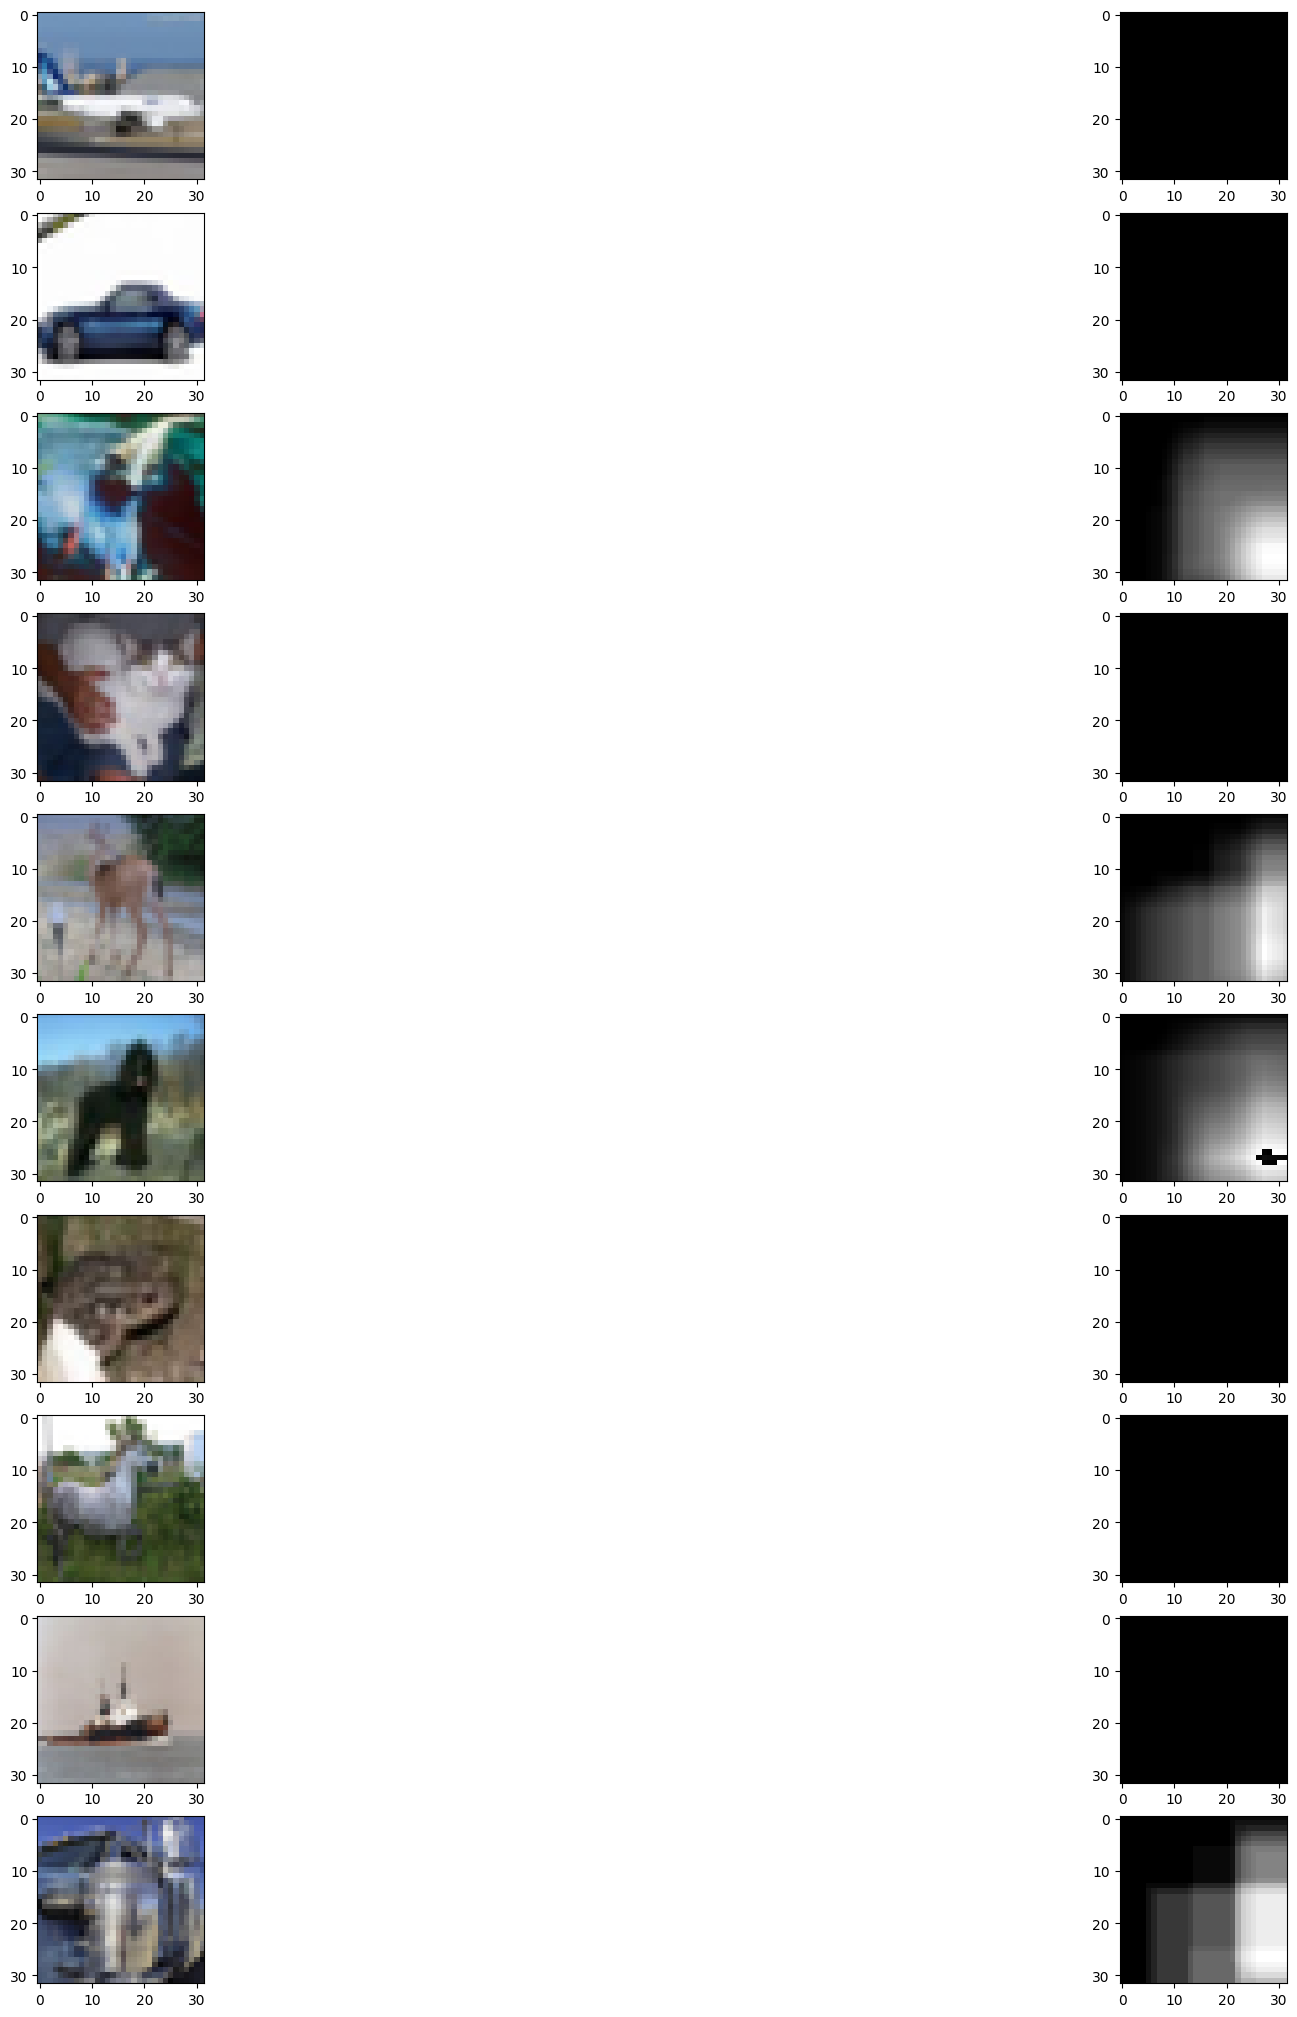

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(10, 2, figsize=(25.6, 25.6))
for k in range(10):
    matrix = calculate_pixel_alteration_matrix(test_images[k], k, patch_size=4, model=dense128ReducedVGG).astype(np.uint8)
    ax[k, 0].imshow((test_images[k] * 255).astype(np.uint8), interpolation='nearest', cmap='gray')
    ax[k, 1].imshow(matrix, interpolation='nearest', cmap='gray')
    k += 1

As we can see, the highest confusion is generated in the right part of the images, and in particular towards the bottom right corner. A somewhat similar result is obtained also with a patch size of $8$:

18/18 [==============================] - 0s 16ms/step


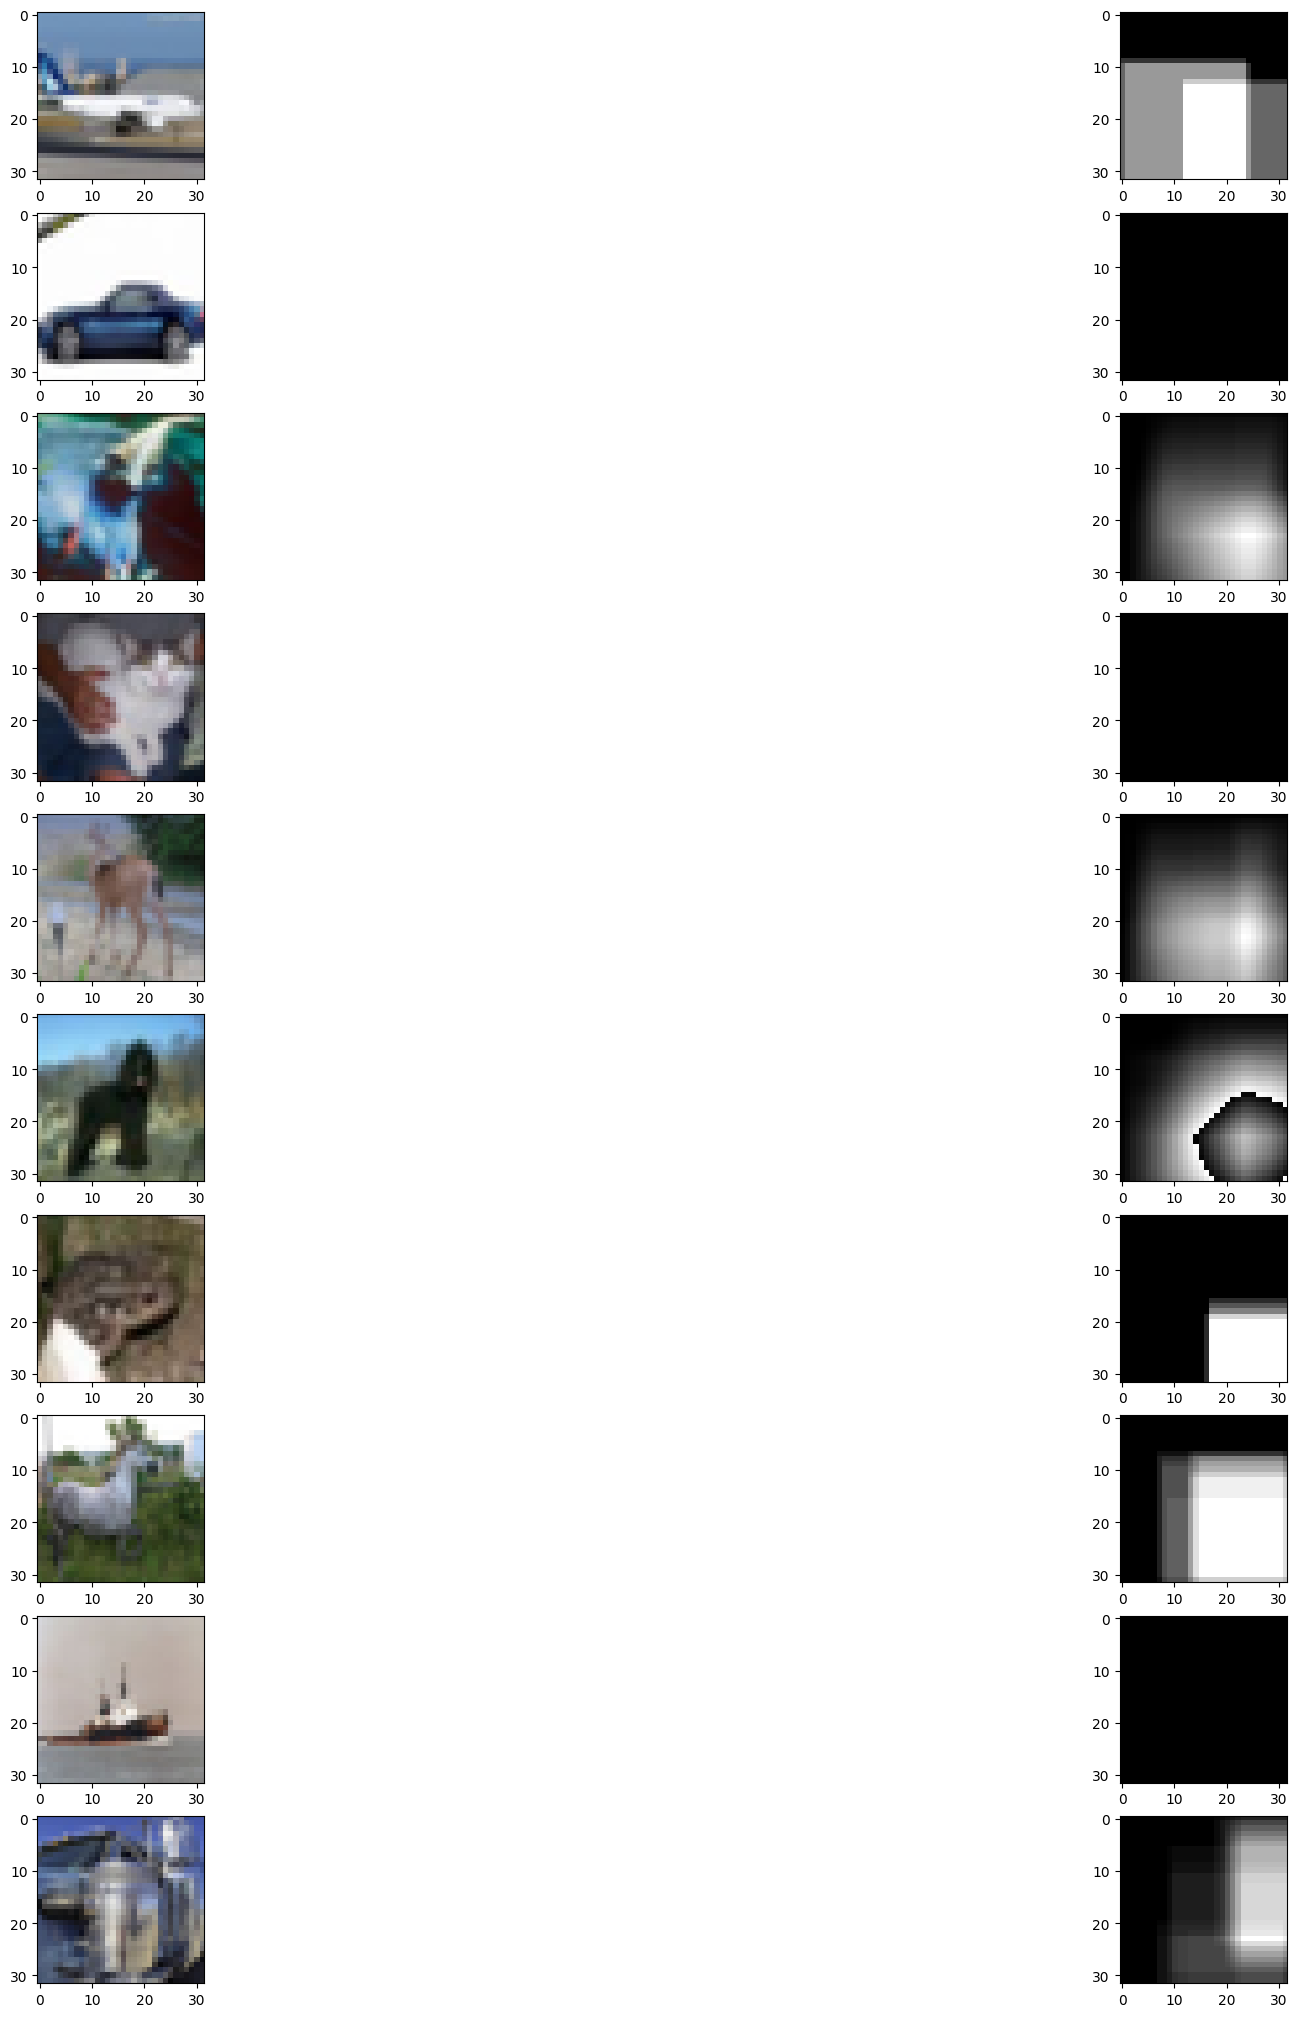

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(10, 2, figsize=(25.6, 25.6))
for k in range(10):
    matrix = calculate_pixel_alteration_matrix(test_images[k], k, patch_size=8, model=dense128ReducedVGG).astype(np.uint8)
    ax[k, 0].imshow((test_images[k] * 255).astype(np.uint8), interpolation='nearest', cmap='gray')
    ax[k, 1].imshow(matrix, interpolation='nearest', cmap='gray')
    k += 1

We may partially explain this behaviour as a consequence of the fact that in images like $0$, $4$, $7$ and $9$ there are key components of the image that are gray.

## Final Considerations
As we have seen, a relatively small (in terms of number of parameters and depth of the network) VGG-inspired model is actually capable of reaching an accuracy of $80-82\%$ on the `CIFAR-10` dataset within $10$ training epochs. As already stated, the choice of a VGG-like model is determined by the goal of getting a tradeoff between high accuracy, training time and model complexity without complicating the design with usage of patterns like `Inception` modules or `Residual Connections`, which are "incompatible" with the approach of VGG networks to progressively extend the number of filters and reduce the sizes of the subsequent feature maps without getting substantial differences in accuracy (I have also experimented with "small" ResNet-style networks  with Residual Connections e.g. between the first and the third Conv2D blocks without getting interesting results). Usage of "architectural" regularization strategies like Dropout and Batch Normalization was actually confirmed to be necessary by the experiments with `baseReducedVGG` in which we saw a clear overfitting happening after a few epochs. For what concerns `Dense` layers, I preferred to keep model simple without having too many parameters and multiple hidden layers, since I have not found any significant improvement by using a single layer of size $256$ or a couple of them. However, finding out if there exist a significantly better sequence of hidden layers with correspondent sizes may be a subject for future works, together with improvements in the architecture.

For future works, we may consider in particular the following:

- with more training time it may be possible to actually implement a deeper network with Residual Connections and Inception modules, getting something more similar to `ResNet` or `GoogLeNet`, and we may expect an outperform in accuracy by such models considering for instance that they *actually* outperformed `VGG-16` with `ImageNet` dataset;
- similarly, we may explore both the usage of $1 \times 1$ convolutions and different architectures for the fully-connected part of the network to seek for accuracy improvements;
- for simplicity in this notebook I fixed a maximum number of epochs of $10$, since it was sufficient to show overfitting in the `baseReducedVGG` model a good estimate of the maximum possible accuracy with a given model and weights initialization, but with more training time it may be possible to actually fix a higher maximum number of epochs and to use e.g. `EarlyStopping` to achieve a higher accuracy;
- for what concerns "occlusion experiments", for simplicity I used only a gray $(128, 128, 128)$ patch, and as already stated before, it may be possible that "bad" results like for class $5$ may have been influenced by the tonality of gray in images in which key objects are gray. Future works may concern exploring different colors for these patches to see if the network is substantially robust to these alterations and maybe these results actually depend on the color of the patch or if there is actually any problem in getting high precision for classes like $5$ (confusion matrix suggests the first hypothesis).